Analysis of TOPAS-nBio simulations of cells with nanoparticles

This notebook analyses the results of the simulations of TOPAS and TOPAS-nbio of cells with nanoparticles irradiated with I125 radiation source.

In [1]:
import sys
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint

# Import our custom modules
from dnadamage_phsp_manager import *
import sddparser
from chemistry_output_manager import *
from phsp_manager import count_phsp_particles
from topas_statistics import TOPASStatistics
from collections import defaultdict
from topas_csv_files_manager import process_csv_file, process_original_hists

## Notebook Functions

This notebook processes the results of multiple TOPAS simulations of cells with nanoparticles. It uses the following imported functions:

- `process_csv_file`: Processes TOPAS CSV files and extracts sum values and histories
- `process_original_hists`: Extracts history values from TOPAS simulation files
- `count_phsp_particles`: Counts particles in phase space files

These functions are organized in the appropriate module files:
- `topas_csv_files_manager.py`: Contains functions for processing TOPAS CSV files
- `phsp_manager.py`: Contains functions for processing phase space files

The notebook processes multiple runs and aggregates results for:
- Original histories
- Dose to nucleus (physical and chemical phases)
- Energy deposited in the cell
- Nanoparticle electron emissions

In [2]:
from analize_cell_sim_results import multirun_processing

# Set parameters for multirun processing
nruns = 100
filebase = '../TOPAS_CellsNPs/work/only_results_CellColony-med1-cell1/cell2'

# Process all runs and get results
Cell_results = multirun_processing(nruns, filebase)


Processing run 100/100...
Processing complete!



Results Summary:
--------------------------------------------------

Physical Quantities:
--------------------------------------------------
Original histories: 60,000,000
Nanoparticle electrons: 3,589 particles

DoseToNucl_ph2:
  - Value: 3.908301e-07 ± 2.671270e-07 (2σ)

DoseToNucl_ph3:
  - Value: 7.324033e-07 ± 5.667942e-07 (2σ)

Ecell:
  - Value: 2.655794e-06 ± 1.295379e-06 (2σ)

Chemical Phase Results (G-Values):
--------------------------------------------------

H3O^1:
  - G-Value: 3.5344 ± 0.4691 molecules/100eV (2σ)

OH^0:
  - G-Value: 3.0434 ± 0.3675 molecules/100eV (2σ)

e_aq^-1:
  - G-Value: 2.6597 ± 0.3188 molecules/100eV (2σ)

H2O2^0:
  - G-Value: 1.3383 ± 0.1910 molecules/100eV (2σ)

H^0:
  - G-Value: 1.1305 ± 0.1745 molecules/100eV (2σ)

H_2^0:
  - G-Value: 1.0230 ± 0.1409 molecules/100eV (2σ)

OH^-1:
  - G-Value: 0.9907 ± 0.1644 molecules/100eV (2σ)

DNA Damage Results:
--------------------------------------------------

Total events: 1,020
Total energy deposited: 7.3

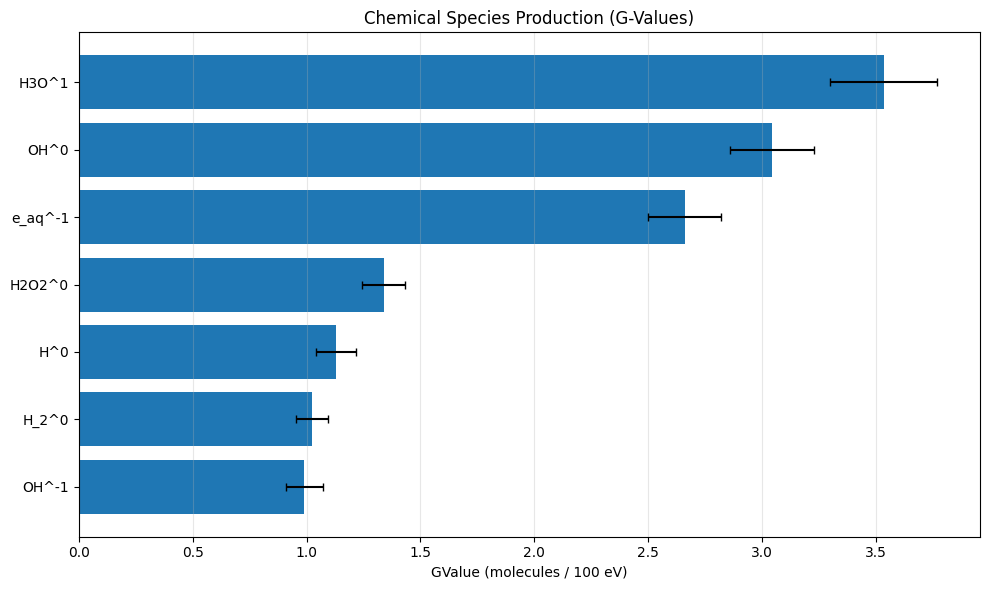

In [ ]:
def display_results(results):
    """Display processed results with proper formatting and error reporting."""
    print("\nResults Summary:")
    print("-" * 50)
    
    # Display physical quantities
    print("\nPhysical Quantities:")
    print("-" * 50)
    
    # Display particle counts
    print(f"Original histories: {results['Original_hists']['value']:,}")
    print(f"Nanoparticle electrons: {results['NP_el']['value']:,} particles")
    
    # Display dose and energy measurements
    for key in ['DoseToNucl_ph2', 'DoseToNucl_ph3', 'Ecell']:
        print(f"\n{key}:")
        print(f"  - Value: {results[key]['value']:.6e} ± {results[key]['error']:.6e} (2σ)")
    
    # Display chemical phase results 
    print("\nChemical Phase Results (G-Values):")
    print("-" * 50)
    
    # Sort species by G-Value for better presentation
    species_data = [(species, data['value'], data['error']) 
                   for species, data in results['GValues'].items() 
                   if 'value' in data]
    species_data.sort(key=lambda x: x[1], reverse=True)
    
    for species, value, error in species_data:
        print(f"\n{species}:")
        print(f"  - G-Value: {value:.4f} ± {error:.4f} molecules/100eV (2σ)")
    
    # Display DNA damage results if available
    if 'DNADamage' in results and 'totals' in results['DNADamage']:
        print("\nDNA Damage Results:")
        print("-" * 50)
        
        # Display total events and energy
        if 'total_events' in results['DNADamage']['totals']:
            print(f"\nTotal events: {results['DNADamage']['totals']['total_events']:,}")
        
        if 'energy' in results['DNADamage']['totals']:
            energy_stats = results['DNADamage']['totals']['energy']
            print(f"Total energy deposited: {energy_stats['total_MeV']:.2f} MeV")
        
        # Group and display damage statistics
        damage_groups = {
            'Double Strand Breaks (DSBs)': ['DSBs', 'DSBs_Direct', 'DSBs_Indirect', 'DSBs_Hybrid'],
            'Single Strand Breaks (SSBs)': ['SSBs', 'SSBs_Direct', 'SSBs_QuasiDirect', 'SSBs_Indirect'],
            'Strand Breaks (SBs)': ['SBs', 'SBs_Direct', 'SBs_QuasiDirect', 'SBs_Indirect'],
            'Base Damage (BDs)': ['BDs', 'BDs_Direct', 'BDs_QuasiDirect', 'BDs_Indirect'],
            'Complex Damage': ['SSB+s', 'DSB+s', 'More complex damages'],
            'Foci': ['Foci_150nm', 'Foci_500nm']
        }
        
        for group_name, damage_types in damage_groups.items():
            relevant_types = [dt for dt in damage_types if dt in results['DNADamage']['totals']]
            if relevant_types:
                print(f"\n{group_name}:")
                for damage_type in relevant_types:
                    total = results['DNADamage']['totals'][damage_type]
                    print(f"  - {damage_type}: {total:.0f}")

In [ ]:
def plot_damage_distribution(damage_totals):
    """Create a stacked bar plot showing direct vs indirect damage distribution."""
    damage_pairs = [
        ('DSBs_Direct', 'DSBs_Indirect'),
        ('SSBs_Direct', 'SSBs_Indirect'),
        ('SBs_Direct', 'SBs_Indirect'),
        ('BDs_Direct', 'BDs_Indirect')
    ]
    
    valid_pairs = [(direct, indirect) for direct, indirect in damage_pairs 
                  if direct in damage_totals and indirect in damage_totals]
    
    if valid_pairs:
        plt.figure(figsize=(10, 6))
        bar_width = 0.35
        x = np.arange(len(valid_pairs))
        labels = [pair[0].split('_')[0] for pair in valid_pairs]
        
        # Plot stacked bars with consistent colors
        direct_color = '#1f77b4'  # blue
        indirect_color = '#ff7f0e'  # orange
        for i, (direct, indirect) in enumerate(valid_pairs):
            direct_sum = damage_totals[direct]
            indirect_sum = damage_totals[indirect]
            plt.bar(i, direct_sum, bar_width, color=direct_color, label='Direct' if i == 0 else "")
            plt.bar(i, indirect_sum, bar_width, bottom=direct_sum, color=indirect_color, label='Indirect' if i == 0 else "")
        
        plt.xlabel('Damage Type')
        plt.ylabel('Count')
        plt.title('Direct vs Indirect Damage Distribution')
        plt.xticks(x, labels)
        plt.legend()
        plt.tight_layout()
        plt.show()

# Create plot of G-values
def plot_gvalues(gvalue_results):
    """Create a horizontal bar plot showing G-values for chemical species."""
    # Convert results to dataframe format
    data = {
        'Species': [],
        'GValue': [],
        'Error': []
    }
    
    for species, result in gvalue_results.items():
        if 'value' in result:
            data['Species'].append(species)
            data['GValue'].append(result['value'])
            data['Error'].append(result['error'] / 2)  # Convert from 2σ to 1σ for error bars
    
    # Convert to DataFrame and sort by GValue
    df = pd.DataFrame(data)
    df = df.sort_values('GValue')
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.barh(
        df['Species'],
        df['GValue'],
        xerr=df['Error'],
        align='center',
        ecolor='black',
        capsize=3
    )
    
    plt.xlabel('GValue (molecules / 100 eV)')
    plt.title('Chemical Species Production (G-Values)')
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

# Display the results
display_results(Cell_results)

# Plot damage distribution if DNA damage data is available
if 'DNADamage' in Cell_results and 'totals' in Cell_results['DNADamage']:
    plot_damage_distribution(Cell_results['DNADamage']['totals'])

# Plot G-values if chemical species data is available    
if any('value' in data for data in Cell_results['GValues'].values()):
    plot_gvalues(Cell_results['GValues'])